In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from src.models import SIRM, SIRT, SIRV


from src.utils.batch_sweep import sweep_two_parameters
from src.utils.visualization import *
from src.utils.visualization.core import Lx, Ly
import numpy as np
from src.models import SIRM, SIRT, SIRV
from helps import *

import jax.numpy as jnp
from matplotlib.gridspec import GridSpec


CH = ["#00441b", "#238b45", "#000", "#66c2a4", "#99d8c9"]       # used for fixed homophily
CP = ["#000", "#7f0000", "#d7301f", "#fc8d59", "#fdbb84"]       # used for fixed polarization
NB = 101
NP = 101

homophilic_tendency = {"m": 0, "M": 6, "n": NB}
pol_range = {"m": 0, "M": 1, "n": NP}


P = [0.1, 0.5, 0.9]


colors_X = ['#66c2a4', '#238b45','#00441b']  # fixed polarization
colors_Y = ['#67001f', '#e7298a', '#df65b0'] # fixed homophily
my_map = discretize_cmaps("hot_r",21)
my_map.set_bad(color='gray')
cmaps = [my_map]
contour_values = [[0.25, 0.5, 0.75]]
contour_colors = [['#000','#000','#000']]
final_params={
        'Lx': Lx,  # Figure width in inches
        'Ly': Ly,  # Figure height in inches
        'xticks': [0, 0.5, 1.0],
        'yticks': [0, 3, 6],
        'xlim': [0, 1],
        'ylim': [0, 6]
    }

temp = read_json("./parameters.json")
mus, taus, xis, PARAMS = temp["mus"], temp["taus"], temp["xis"], temp["PARAMS"]
rect_coords_M = [mus["pol"][0], mus["h"][0], mus["pol"][2]-mus["pol"][0], mus["h"][2]-mus["h"][0]]
rect_coords_T = [taus["pol"][0], taus["h"][0], taus["pol"][2]-taus["pol"][0], taus["h"][2]-taus["h"][0]]
rect_coords_V = [xis["pol"][0], xis["h"][0], xis["pol"][2]-xis["pol"][0], xis["h"][2]-xis["h"][0]]

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

def simple_parameter_grid(data_matrices, nrows, ncols, figsize=(10, 8), 
                         cmap='viridis', vmin=0, vmax=1, extent=[0, 1, 0, 6]):
    """
    Super duper simple version - just plot matrices with colorbars
    
    Args:
        data_matrices: List of 2D arrays to plot
        nrows, ncols: Grid dimensions
        figsize: Figure size
        cmap: Colormap
        vmin, vmax: Color scale limits
        
    Returns:
        fig, axes
    """
    # Create figure with extra column for colorbars
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(nrows, ncols + 1, figure=fig, width_ratios=[1] * ncols + [0.05])
    
    # Create axes
    axes = np.empty((nrows, ncols), dtype=object)
    for i in range(nrows):
        for j in range(ncols):
            axes[i, j] = fig.add_subplot(gs[i, j])
    
    cbar_axes = []
    for i in range(nrows):
        cbar_axes.append(fig.add_subplot(gs[i, -1]))
    
    # Plot matrices
    for i in range(nrows):
        for j in range(ncols):
            idx = i * ncols + j
            
            if idx < len(data_matrices):
                data = data_matrices[idx]
                im = axes[i, j].imshow(
                    np.flipud(data), 
                    cmap=cmap, 
                    vmin=vmin, 
                    vmax=vmax,
                    aspect='auto',
                    extent=extent
                )
                
                # Add colorbar for first column of each row
                if j == 0:
                    fig.colorbar(im, cax=cbar_axes[i])
    
    return fig, axes, cbar_axes

In [39]:
N_compartments = [3, 5, 11, 31, 101]
RM = []
RT = []
RV = []


for N in N_compartments:
    res = sweep_two_parameters(
        model_module=SIRM,
        param1_name="beta_params",           # parameter 1 name
        param1_range=pol_range,    # parameter 1 range
        param2_name="homophilic_tendency",      # parameter 2 name
        param2_range=homophilic_tendency,         # parameter 2 range
        custom_base_params=PARAMS,
        simulated_days=1000,
        population_size=N,
        batch_size=1000
    )
    RM.append(res)
    res = sweep_two_parameters(
        model_module=SIRT,
        param1_name="beta_params",           # parameter 1 name
        param1_range=pol_range,    # parameter 1 range
        param2_name="homophilic_tendency",      # parameter 2 name
        param2_range=homophilic_tendency,         # parameter 2 range
        custom_base_params=PARAMS,
        simulated_days=1000,
        population_size=N,
        batch_size=1000
    )
    RT.append(res)
    res = sweep_two_parameters(
        model_module=SIRV,
        param1_name="beta_params",           # parameter 1 name
        param1_range=pol_range,    # parameter 1 range
        param2_name="homophilic_tendency",      # parameter 2 name
        param2_range=homophilic_tendency,         # parameter 2 range
        custom_base_params=PARAMS,
        simulated_days=1000,
        population_size=N,
        batch_size=1000
    )
    RV.append(res)

    print(f"Finished {N} compartments")

Finished 3 compartments
Finished 5 compartments
Finished 11 compartments
Finished 31 compartments
Finished 101 compartments


In [41]:
# concatenate all results
results = RM + RT + RV

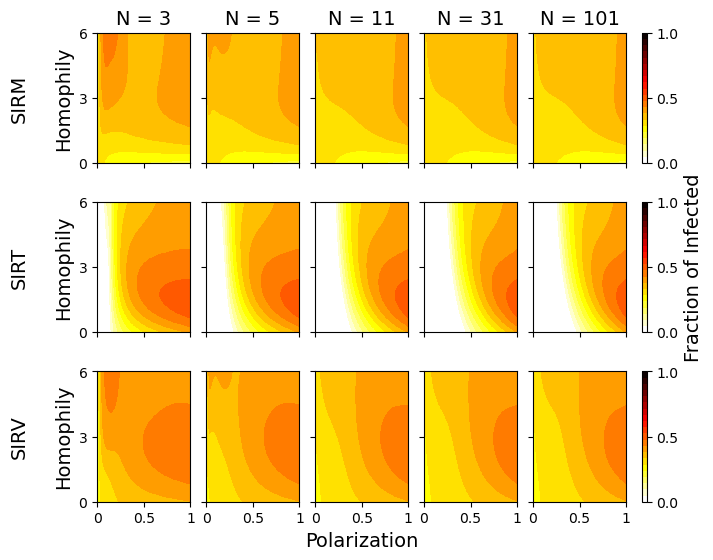

In [46]:
matrices = []
for i in range(len(results)):
    TI = np.sum(results[i]["final_state"]["R"], axis=2) + np.sum(results[i]["final_state"]["I"], axis=2)
    matrices.append(TI)

fig, plot_axes, cbar_axes = simple_parameter_grid(matrices, 3, 5, cmap=my_map, vmin=0, vmax=1, figsize=(7.09, 6.09))
plt.subplots_adjust(hspace=0.3, wspace=0.2)


for i in range(3):
    for j in range(5):
        plot_axes[i, j].set_xticks([0, 0.5, 1])
        plot_axes[i, j].set_yticks([0, 3, 6])
        plot_axes[i, j].set_xticklabels([0, 0.5, 1])
        

        if j > 0:
            plot_axes[i, j].set_yticklabels([])
        else:
            plot_axes[i, j].set_yticklabels([0, 3, 6])

        if i < 2:
            plot_axes[i, j].set_xticklabels([])
        else:
            plot_axes[i, j].set_xticklabels([0, 0.5, 1])


plot_axes[0, 0].set_ylabel("SIRM\n\nHomophily", fontsize=14)
plot_axes[1, 0].set_ylabel("SIRT\n\nHomophily", fontsize=14)
plot_axes[2, 0].set_ylabel("SIRV\n\nHomophily", fontsize=14)

plot_axes[2, 2].set_xlabel("Polarization", fontsize=14)


cbar_axes[0].set_yticks([0, 0.5, 1])
cbar_axes[1].set_ylabel("Fraction of Infected", fontsize=14)
cbar_axes[1].set_yticks([0, 0.5, 1])
cbar_axes[2].set_yticks([0, 0.5, 1])


plot_axes[0, 0].set_title("N = " + str(N_compartments[0]), fontsize=14)
plot_axes[0, 1].set_title("N = " + str(N_compartments[1]), fontsize=14)
plot_axes[0, 2].set_title("N = " + str(N_compartments[2]), fontsize=14)
plot_axes[0, 3].set_title("N = " + str(N_compartments[3]), fontsize=14)
plot_axes[0, 4].set_title("N = " + str(N_compartments[4]), fontsize=14)


fig.savefig("figures/SI/Dependency_on_NCOMPARTMENTS.pdf", dpi=150, bbox_inches='tight')

In [47]:
MU_m = [0. , 0.2, 0.4]
MU_M = [0.6, 0.8, 1.]


RES_M_mumu = []


for i in range(3):
    for j in range(3):
        CB =PARAMS.copy()
        CB["mu_min"] = MU_m[i]
        CB["mu_max"] = MU_M[j]
        res = sweep_two_parameters(
            model_module=SIRM,
            param1_name="beta_params",           # parameter 1 name
            param1_range=pol_range,    # parameter 1 range
            param2_name="homophilic_tendency",      # parameter 2 name
            param2_range=homophilic_tendency,         # parameter 2 range
            custom_base_params=CB,
            simulated_days=1000,
            population_size=5,
            batch_size=1000
        )
        RES_M_mumu.append(res)


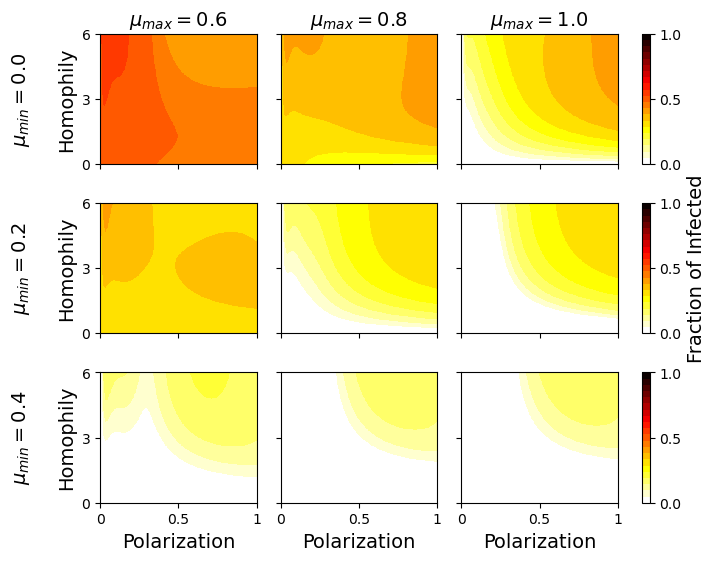

In [55]:
matrices = []
for i in range(len(RES_M_mumu)):
    TI = np.sum(RES_M_mumu[i]["final_state"]["R"], axis=2) + np.sum(RES_M_mumu[i]["final_state"]["I"], axis=2)
    matrices.append(TI)

fig, plot_axes, cbar_axes = simple_parameter_grid(matrices, 3, 3, cmap=my_map, vmin=0, vmax=1, figsize=(7.09, 6.09))
plt.subplots_adjust(hspace=0.3, wspace=0.2)


for i in range(3):
    for j in range(3):
        plot_axes[i, j].set_xticks([0, 0.5, 1])
        plot_axes[i, j].set_yticks([0, 3, 6])
        plot_axes[i, j].set_xticklabels([0, 0.5, 1])
        plot_axes[i, j].set_yticklabels([0, 3, 6])
        if i < 2:
            plot_axes[i, j].set_xticklabels([])
        if j > 0:
            plot_axes[i, j].set_yticklabels([])
    cbar_axes[i].set_yticks([0, 0.5, 1])
    plot_axes[i, 0].set_ylabel(r"$\mu_{min} = " + f"{MU_m[i]}" + r"$" + "\n\nHomophily", fontsize=14)
    plot_axes[2, i].set_xlabel("Polarization", fontsize=14)
    plot_axes[0, i].set_title(r"$\mu_{max} = " + f"{MU_M[i]}" + r"$", fontsize=14)

cbar_axes[1].set_ylabel("Fraction of Infected", fontsize=14)

fig.savefig("figures/SI/MIN-MAX_SIRM.pdf", dpi=150, bbox_inches='tight')

In [18]:
R0s = np.linspace(1, 5, 9)
gamma = np.array([0.1]*  9)
beta = R0s * gamma
RES_M_betagamma = []

for i in range(9):
    CB =PARAMS.copy()
    CB["mu_min"] = 0
    CB["mu_max"] = 0.8
    CB["beta_M"] = beta[i]
    CB["recovery_rate"] = gamma[i]
    res = sweep_two_parameters(
        model_module=SIRM,
        param1_name="beta_params",           # parameter 1 name
        param1_range=pol_range,    # parameter 1 range
        param2_name="homophilic_tendency",      # parameter 2 name
        param2_range=homophilic_tendency,         # parameter 2 range
        custom_base_params=CB,
        simulated_days=10000,
        population_size=5,
        batch_size=10000
    )
    RES_M_betagamma.append(res)



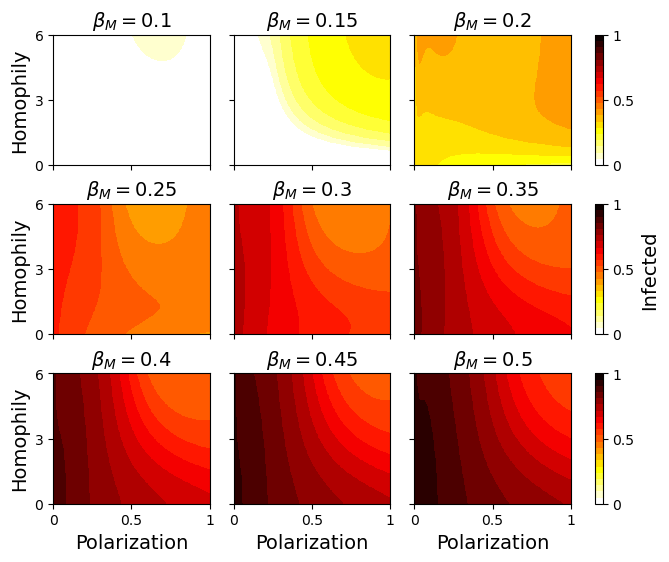

In [14]:
matrices = []
for i in range(9):
    TI = np.sum(RES_M_betagamma[i]["final_state"]["R"], axis=2) + np.sum(RES_M_betagamma[i]["final_state"]["I"], axis=2)
    matrices.append(TI)
fig, axes, cbar_axes = simple_parameter_grid(matrices, 3, 3, cmap=my_map, vmin=0, vmax=1, figsize=(7.09, 6.09))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

count = 0
for i in range(3):
    for j in range(3):
        axes[i, j].set_xticks([0, 0.5, 1])
        axes[i, j].set_yticks([0, 3, 6])
        axes[i, j].set_xticklabels([0, 0.5, 1])
        axes[i, j].set_yticklabels([0, 3, 6])
        if i < 2:
            axes[i, j].set_xticklabels([])
        if j > 0:
            axes[i, j].set_yticklabels([])
        axes[i, j].set_title(r"$\beta_M = $" + str(np.round(R0s[count]*0.1, 2)), fontsize=14)
        count += 1

    axes[2, i].set_xlabel("Polarization", fontsize=14)
    axes[i, 0].set_ylabel("Homophily", fontsize=14)
    cbar_axes[i].set_yticks([0, 0.5, 1])
    cbar_axes[i].set_yticklabels([0, 0.5, 1])
    if i == 1:
        cbar_axes[i].set_ylabel("Infected", fontsize=14)
    



fig.savefig("figures/SI/SIRM_beta_gamma.pdf", dpi=150, bbox_inches='tight')


In [62]:
TAU_m = [0, 0.025, 0.05]
TAU_M = [0.1 , 0.2,  0.3]

CB =PARAMS.copy()
RES_T_tautau = []
for i in range(3):
    for j in range(3):
        CB["testing_rate_min"] = TAU_m[i]
        CB["testing_rate_max"] = TAU_M[j]
        results_TESTS_00 = sweep_two_parameters(
            model_module=SIRT,
            param1_name="beta_params",           # parameter 1 name
            param1_range=pol_range,    # parameter 1 range
            param2_name="homophilic_tendency",      # parameter 2 name
            param2_range=homophilic_tendency,         # parameter 2 range
            custom_base_params=CB,
            simulated_days=1000,
            population_size=5,
            batch_size=1000
        )
        RES_T_tautau.append(results_TESTS_00)


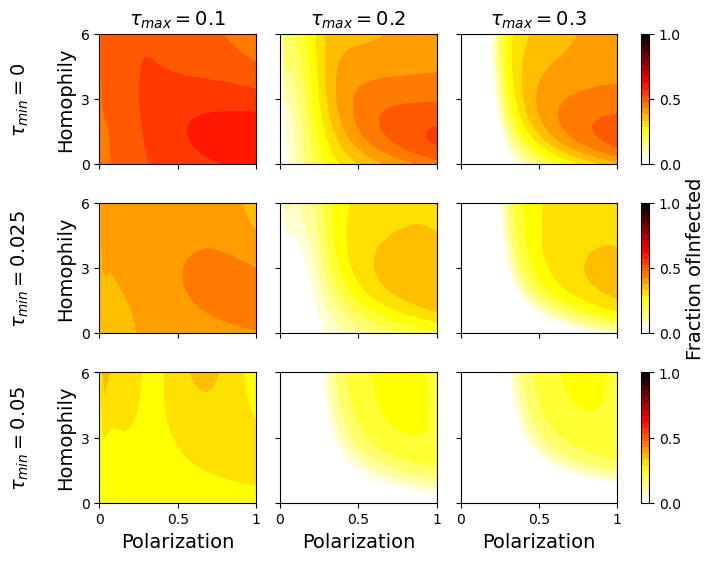

In [78]:
matrices = []
for i in range(len(RES_T_tautau)):
    TI = np.sum(RES_T_tautau[i]["final_state"]["R"], axis=2) + np.sum(RES_T_tautau[i]["final_state"]["I"], axis=2)
    matrices.append(TI)

fig, plot_axes, cbar_axes = simple_parameter_grid(matrices, 3, 3, cmap=my_map, vmin=0, vmax=1, figsize=(7.09, 6.09))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

count = 0
for i in range(3):
    for j in range(3):
        plot_axes[i, j].set_xticks([0, 0.5, 1])
        plot_axes[i, j].set_yticks([0, 3, 6])
        plot_axes[i, j].set_xticklabels([0, 0.5, 1])
        plot_axes[i, j].set_yticklabels([0, 3, 6])
        if i < 2:
            plot_axes[i, j].set_xticklabels([])
        if j > 0:
            plot_axes[i, j].set_yticklabels([])
        count += 1

    cbar_axes[i].set_yticks([0, 0.5, 1])
    plot_axes[i, 0].set_ylabel(r"$\tau_{min} = " + f"{TAU_m[i]}" + r"$" + "\n\nHomophily", fontsize=14)
    plot_axes[2, i].set_xlabel("Polarization", fontsize=14)
    plot_axes[0, i].set_title(r"$\tau_{max} = " + f"{TAU_M[i]}" + r"$", fontsize=14)
    if i == 1:
        cbar_axes[i].set_ylabel("Fraction ofInfected", fontsize=14)
    



fig.savefig("figures/SI/MIN-MAX_SIRT.pdf", dpi=150, bbox_inches='tight')

In [65]:
XIS_m = np.array([0.   , 0.002, 0.004])
XIS_M = np.array([0.006, 0.008 , 0.01])

CB =PARAMS.copy()
RES_XIS_xisxis = []
for i in range(3):
    for j in range(3):
        CB["vaccination_rate_min"] = XIS_m[i]
        CB["vaccination_rate_max"] = XIS_M[j]
        results_VACCINATION_00 = sweep_two_parameters(
            model_module=SIRV,
            param1_name="beta_params",           # parameter 1 name
            param1_range=pol_range,    # parameter 1 range
            param2_name="homophilic_tendency",      # parameter 2 name
            param2_range=homophilic_tendency,         # parameter 2 range
            custom_base_params=CB,
            simulated_days=1000,
            population_size=5,
            batch_size=1000
        )
        RES_XIS_xisxis.append(results_VACCINATION_00)

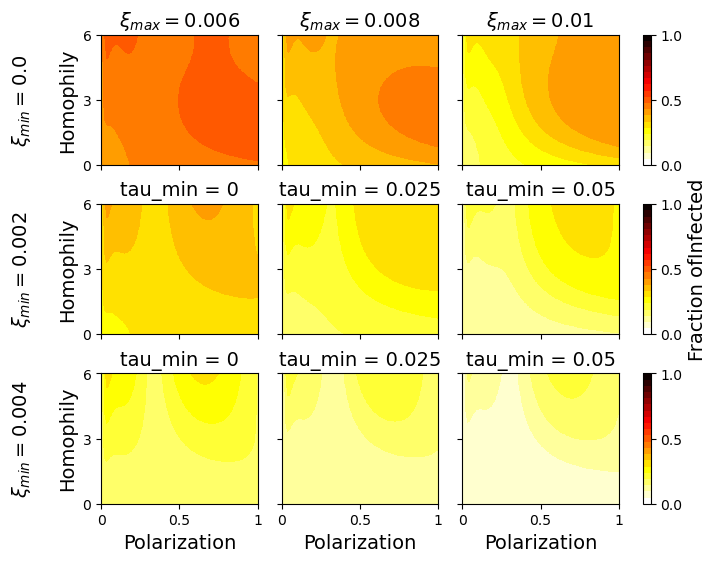

In [72]:
matrices = []
for i in range(len(RES_XIS_xisxis)):
    TI = np.sum(RES_XIS_xisxis[i]["final_state"]["R"], axis=2) + np.sum(RES_XIS_xisxis[i]["final_state"]["I"], axis=2)
    matrices.append(TI)
fig, plot_axes, cbar_axes = simple_parameter_grid(matrices, 3, 3, cmap=my_map, vmin=0, vmax=1, figsize=(7.09, 6.09))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

count = 0
for i in range(3):
    for j in range(3):
        plot_axes[i, j].set_xticks([0, 0.5, 1])
        plot_axes[i, j].set_yticks([0, 3, 6])
        plot_axes[i, j].set_xticklabels([0, 0.5, 1])
        plot_axes[i, j].set_yticklabels([0, 3, 6])
        if i < 2:
            plot_axes[i, j].set_xticklabels([])
        if j > 0:
            plot_axes[i, j].set_yticklabels([])
        plot_axes[i, j].set_title(f"tau_min = {TAU_m[j]}", fontsize=14)
        count += 1

    cbar_axes[i].set_yticks([0, 0.5, 1])
    plot_axes[i, 0].set_ylabel(r"$\xi_{min} = " + f"{XIS_m[i]}" + r"$" + "\n\nHomophily", fontsize=14)
    plot_axes[2, i].set_xlabel("Polarization", fontsize=14)
    plot_axes[0, i].set_title(r"$\xi_{max} = " + f"{XIS_M[i]}" + r"$", fontsize=14)
    if i == 1:
        cbar_axes[i].set_ylabel("Fraction ofInfected", fontsize=14)


fig.savefig("figures/SI/MIN-MAX_SIRV.pdf.pdf", dpi=150, bbox_inches='tight')




In [69]:
I0s = np.array([1e-6, 1e-5, 1e-4, 1e-3])
XIS_M = np.array([0.006, 0.008 , 0.01])

CB =PARAMS.copy()
RES_XIS_xisxis_I0s = []
for i in range(4):
    for j in range(3):
        CB["vaccination_rate_min"] = 0
        CB["vaccination_rate_max"] = XIS_M[j]
        
        results_VACCINATION_00 = sweep_two_parameters(
            model_module=SIRV,
            param1_name="beta_params",           # parameter 1 name
            param1_range=pol_range,    # parameter 1 range
            param2_name="homophilic_tendency",      # parameter 2 name
            param2_range=homophilic_tendency,         # parameter 2 range
            custom_base_params=CB,
            simulated_days=1000,
            population_size=5,
            batch_size=1000,
            initial_infected_prop=I0s[i]
        )
        RES_XIS_xisxis_I0s.append(results_VACCINATION_00)

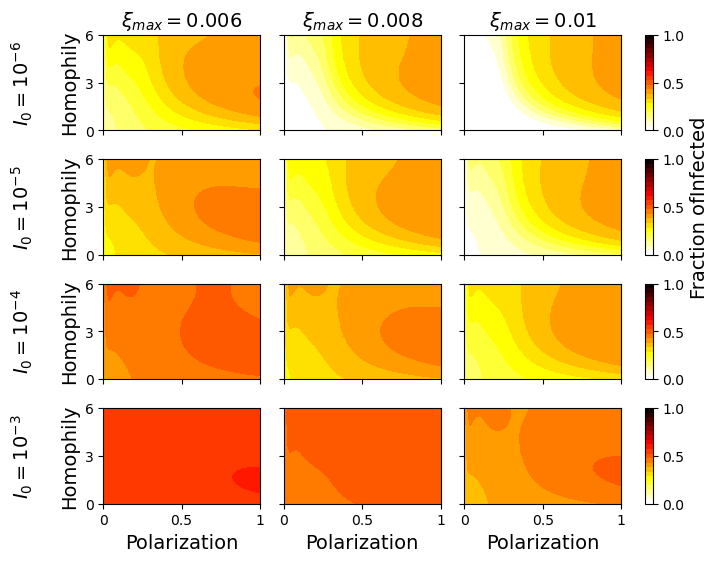

In [85]:
matrices = []
for i in range(len(RES_XIS_xisxis_I0s)):
    TI = np.sum(RES_XIS_xisxis_I0s[i]["final_state"]["R"], axis=2) + np.sum(RES_XIS_xisxis_I0s[i]["final_state"]["I"], axis=2)
    matrices.append(TI)
fig, plot_axes, cbar_axes = simple_parameter_grid(matrices, 4, 3, cmap=my_map, vmin=0, vmax=1, figsize=(7.09, 6.09))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

count = 0
for i in range(4):
    for j in range(3):
        plot_axes[i, j].set_xticks([0, 0.5, 1])
        plot_axes[i, j].set_yticks([0, 3, 6])
        if i < 3:
            plot_axes[i, j].set_xticklabels([])
        else:
            plot_axes[i, j].set_xticklabels([0, 0.5, 1])
        if j > 0:
            plot_axes[i, j].set_yticklabels([])
        else:
            plot_axes[i, j].set_yticklabels([0, 3, 6])
        count += 1

    cbar_axes[i].set_yticks([0, 0.5, 1])
    plot_axes[i, 0].set_ylabel(r"$I_0 = 10^{" + f"{int(np.log10(I0s[i]))}" + r"}$" + "\n\nHomophily", fontsize=14)
    if i == 1:
        cbar_axes[i].set_ylabel("Fraction ofInfected", fontsize=14)

for j in range(3):
    plot_axes[3, j].set_xlabel("Polarization", fontsize=14)
    plot_axes[0, j].set_title(r"$\xi_{max} = " + f"{XIS_M[j]}" + r"$", fontsize=14)


fig.savefig("figures/SI/SIRV_I0.pdf", dpi=150, bbox_inches='tight')

In [86]:
mean_range = {"m": 0, "M": 1, "n": 100}
H = [0, 3, 6]
RES = []


for i in range(3):
    CB =PARAMS.copy()
    CB["homophilic_tendency"] = H[i]

    temp = sweep_two_parameters(
        model_module=SIRM,
        param1_name="beta_params",           # polarization parameter
        param1_range=pol_range,    
        param2_name="mean",                  # average behavior parameter
        param2_range=mean_range,             # range for mean behavior (0 to 1)
        custom_base_params=CB,
        simulated_days=1000,
        population_size=5,
        batch_size=1000
    )
    RES.append(temp)
    temp = sweep_two_parameters(
        model_module=SIRT,
        param1_name="beta_params",           # polarization parameter
        param1_range=pol_range,    
        param2_name="mean",                  # average behavior parameter
        param2_range=mean_range,             # range for mean behavior (0 to 1)
        custom_base_params=CB,
        simulated_days=1000,
        population_size=5,
        batch_size=1000
    )
    RES.append(temp)
    temp = sweep_two_parameters(
        model_module=SIRV,
        param1_name="beta_params",           # polarization parameter
        param1_range=pol_range,    
        param2_name="mean",                  # average behavior parameter
        param2_range=mean_range,             # range for mean behavior (0 to 1)
        custom_base_params=CB,
        simulated_days=1000,
        population_size=5,
        batch_size=1000
    )
    RES.append(temp)

In [87]:
len(RES)

9

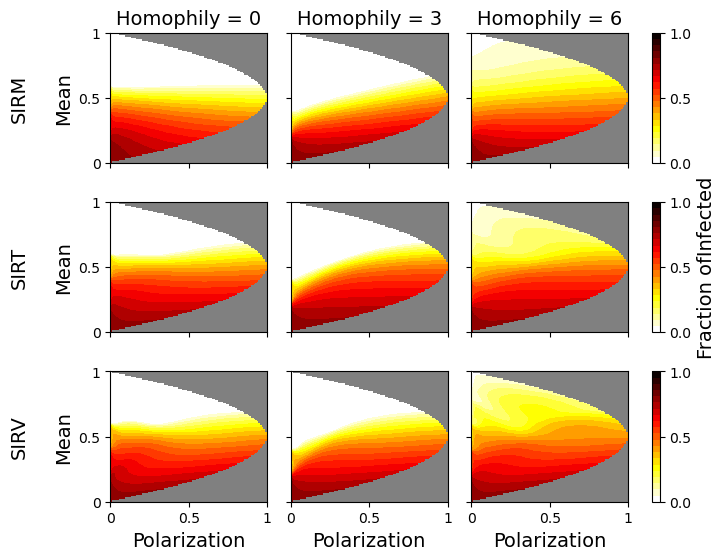

In [98]:
matrices = []
for i in range(len(RES)):
    TI = np.sum(RES[i]["final_state"]["R"], axis=2) + np.sum(RES[i]["final_state"]["I"], axis=2)
    matrices.append(TI)

fig, plot_axes, cbar_axes = simple_parameter_grid(matrices, 3, 3, cmap=my_map, vmin=0, vmax=1, figsize=(7.09, 6.09), extent=[0, 1, 0, 1])
plt.subplots_adjust(hspace=0.3, wspace=0.2)

homophily = [0, 3, 6]

for i in range(3):
    for j in range(3):
        plot_axes[i, j].set_xticks([0, 0.5, 1])
        plot_axes[i, j].set_yticks([0, 0.5, 1])
        plot_axes[i, j].set_xticklabels([0, 0.5, 1])
        plot_axes[i, j].set_yticklabels([0, 0.5, 1])
        if i < 2:
            plot_axes[i, j].set_xticklabels([])
        if j > 0:
            plot_axes[i, j].set_yticklabels([])
    plot_axes[0, i].set_title(f"Homophily = {homophily[i]}", fontsize=14)


    cbar_axes[i].set_yticks([0, 0.5, 1])
    plot_axes[2, i].set_xlabel("Polarization", fontsize=14)
    if i == 1:
        cbar_axes[i].set_ylabel("Fraction ofInfected", fontsize=14)

plot_axes[0, 0].set_ylabel("SIRM\n\nMean", fontsize=14)
plot_axes[1, 0].set_ylabel("SIRT\n\nMean", fontsize=14)
plot_axes[2, 0].set_ylabel("SIRV\n\nMean", fontsize=14)



fig.savefig("figures/SI/mean_comparison.pdf", dpi=150, bbox_inches='tight')
